prerequisites

In [1]:
import numpy as np
import seaborn
import torch
import torch.nn.functional as F
from matplotlib import pyplot
from torchvision import datasets, transforms
from tqdm.auto import tqdm
seaborn.set()  # pretty figures
device = 'cpu'  # set to 'cuda' if you have a GPU with CUDA

MNIST because quickly trains on CPU

In [2]:
preprocessing = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean+std
                       ])
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=preprocessing)
mnist_test = datasets.MNIST('./data', train=False, transform=preprocessing)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1000, shuffle=True, num_workers=8)

show some images

C:\Users\Martin\AppData\Local\conda\conda\envs\pytorch_tutorial\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


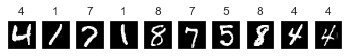

In [3]:
np.random.seed(0)
bunch_of_images = np.random.randint(len(mnist_train), size=10)
bunch_of_images = [mnist_train[i] for i in bunch_of_images]
fig, axes = pyplot.subplots(ncols=len(bunch_of_images))
for ax, (image_tensor, label) in zip(axes, bunch_of_images):
    ax.imshow(image_tensor.numpy().squeeze(), cmap='gray')
    ax.set_title(label)
    ax.set_xticks([])
    ax.set_yticks([])
fig.show()


single-layer

make network

In [4]:
class SingleLayerNet(torch.nn.Module):
    def __init__(self):
        super(SingleLayerNet, self).__init__()
        self.fc = torch.nn.Linear(28 * 28, 10)
        
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # flatten width x height, but not the batch
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    

train

In [8]:
def train(model, data_loader, num_epochs=5, learning_rate=0.01, momentum=0.5, device='cpu'):
    model.train()  # set model into training mode: notify e.g. dropout/batchnorm layers
    # The loss is a differentiable scalar telling us how far off we are.
    # This function will also backward-compute the contribution of all parameters to the output (i.e. the gradients)
    loss = F.nll_loss
    # The optimizer uses the computed gradients to update the weights
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    losses = []
    step_progressbar = tqdm(total=num_epochs * len(data_loader.dataset), desc='training steps')
    for epoch in range(num_epochs):
        for batch_inputs, batch_targets in data_loader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            optimizer.zero_grad()  # reset gradients
            predictions = model(batch_inputs)
            batch_loss = loss(predictions, batch_targets)
            batch_loss.backward()  # backward step: compute gradients
            optimizer.step()  # optimizer step: apply gradients to parameters
            step_progressbar.update(len(batch_inputs))
            step_progressbar.set_postfix(loss=batch_loss.item(), epoch=epoch)
            losses.append(batch_loss.item())
    return losses

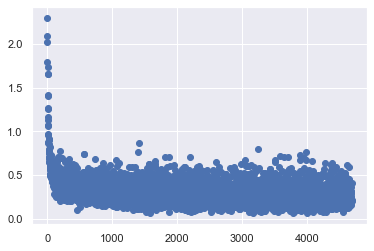

In [9]:
naive_net = SingleLayerNet()
naive_net = naive_net.to(device)
losses = train(naive_net, train_loader, device=device)
pyplot.scatter(x=list(range(len(losses))), y=losses)

test

In [10]:
def test(model, data, device='cpu'):
    model.eval()
    correct = 0
    with torch.no_grad():  # no need to compute gradients
        for batch_inputs, batch_targets in data:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            softmax_output = model(batch_inputs)
            predictions = softmax_output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += predictions.eq(batch_targets.view_as(predictions)).sum().item()
    return 100 * correct / len(data.dataset)
    

In [11]:
train_accuracy = test(naive_net, train_loader, device=device)
test_accuracy = test(naive_net, test_loader, device=device)
print(f"Train top-1: {train_accuracy:.2f}% | Test top-1: {test_accuracy:.2f}%")

Train top-1: 92.35% | Test top-1: 92.04%


multi-layer model

In [ ]:
class DeepNet(torch.nn.Module):
    def __init__(self):
        super(DeepNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 20, 5, 1)
        self.conv2 = torch.nn.Conv2d(20, 50, 5, 1)
        self.fc1 = torch.nn.Linear(4*4*50, 500)
        self.fc2 = torch.nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

deepnet = DeepNet()
deepnet = deepnet.to(device)
losses = train(deepnet, train_loader, num_epochs=10, device=device)
pyplot.scatter(x=list(range(len(losses))), y=losses)
pyplot.show()

train_accuracy = test(deepnet, train_loader, device=device)
test_accuracy = test(deepnet, test_loader, device=device)
print(f"Train top-1: {train_accuracy:.2f}% | Test top-1: {test_accuracy:.2f}%")


side blow: compare with TensorFlow's MNIST implementation: 
https://github.com/tensorflow/models/blob/master/official/mnist/mnist.py

quick training FAQ (following Andrew Ng's deep learning recipe)

* model can't fit the data? 
    
    -> bigger network
    
    -> train longer
    
    -> different architecture
    
* low accuracy on test data?

    -> more data
    
    -> more regularization
    
    -> different architecture

weight & feature visualization

In [ ]:
fig, axes = pyplot.subplots(nrows=len(model))
for ax, layer in zip(axes, model.modules):
    ax.hist(layer.weight)
    ax.set_title(layer.name)
fig.show()


maybe segmentation?